In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG

%pylab inline

2022-08-06 17:10:40.806197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 17:10:40.806224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Populating the interactive namespace from numpy and matplotlib


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Dataset A - All publishers

In [2]:
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)
    
X_test,y_test = data[1],data[4]

y_test_hotcode = keras.utils.to_categorical(y_test)

In [3]:
model_path = "model_h5_file"

In [4]:
os.listdir('model_h5_file')

['mobilnetv2_trainable_array.h5',
 'cnn_model.h5',
 'vgg16_model_array.h5',
 'Xception_model_array_trainable.h5',
 'Xception_model_array.h5',
 'mobilnetv2_base_array.h5']

In [5]:
model_eval ={'accuracy':[],'recall':[],'precision':[],'f1':[],'run_time':[]}
models = []
for model in os.listdir('model_h5_file'):
    models.append(model)
    classification = keras.models.load_model('model_h5_file/'+str(model))
    time1= time.time()
    y_pred = classification.predict(X_test)
    time2= time.time()
    run_time = time2-time1
    y_pred = np.argmax(y_pred,axis =1)
    model_eval['accuracy'].append(accuracy_score(y_test, y_pred))
    model_eval['recall'].append(recall_score(y_test,y_pred,average = 'macro'))
    model_eval['precision'].append(precision_score(y_test, y_pred,average= 'macro'))
    model_eval['f1'].append(f1_score(y_test, y_pred, average = 'macro'))
    model_eval['run_time'].append(run_time)

2022-08-04 08:39:01.855236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 08:39:01.855270: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 08:39:01.855294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fabian-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-04 08:39:01.855558: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 08:39:03.908145: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 513540000 exc

In [6]:
model_eval = pd.DataFrame(model_eval,index = models)
model_eval

accuracy    recall  precision        f1  \
mobilnetv2_trainable_array.h5      0.341220  0.250000   0.085305  0.127205   
cnn_model.h5                       0.387487  0.336131   0.358029  0.321290   
vgg16_model_array.h5               0.436909  0.412385   0.408664  0.406802   
Xception_model_array_trainable.h5  0.417981  0.401676   0.400933  0.397134   
Xception_model_array.h5            0.410620  0.368455   0.427191  0.345746   
mobilnetv2_base_array.h5           0.400105  0.397005   0.402469  0.389216   

                                    run_time  
mobilnetv2_trainable_array.h5      12.658987  
cnn_model.h5                        3.814294  
vgg16_model_array.h5               47.056915  
Xception_model_array_trainable.h5  21.157846  
Xception_model_array.h5            21.232836  
mobilnetv2_base_array.h5            8.095628

In [15]:
int_category_map = {1: 'spiegel', 3:'zeit', 0:'faz', 2:'sz'}

In [16]:
best_model = keras.models.load_model(model_path+ "/"+"vgg16_model_array.h5")
y_pred = np.argmax(best_model.predict(X_test),axis =1)

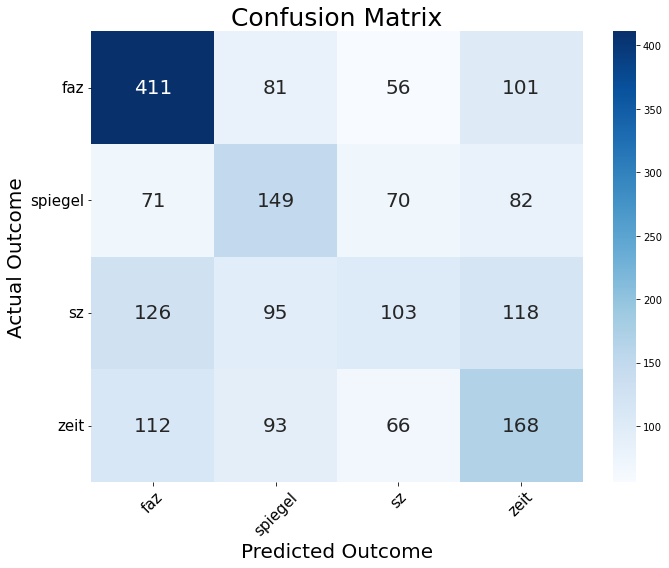

In [17]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Check Data with wrong prediction results**

In [18]:
df = pd.read_csv("work_data_df",index_col = 0)
df_test = df[df['class'] == "test"] 
pred_cate = [int_category_map.get(i) for i in y_pred]
df_test['pred_cate'] = pred_cate
df_test.category = df_test.category.str[7:]
df_test_incorrect = df_test[df_test.category != df_test.pred_cate]

df_test_correct_faz = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category == 'faz'), 'image_path']
df_test_incorrect_faz = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category != 'faz'), 'image_path']

df_test_correct_sz = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category == 'sz'), 'image_path']
df_test_incorrect_sz = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category != 'sz'), 'image_path']

df_test_correct_spiegel = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category == 'spiegel'), 'image_path']
df_test_incorrect_spiegel = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category != 'spiegel'), 'image_path']

df_test_correct_zeit = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category == 'zeit'), 'image_path']
df_test_incorrect_zeit = df_test.loc[(df_test.category == df_test.pred_cate) & 
                                  (df_test.category != 'zeit'), 'image_path']

/tmp/ipykernel_1290055/2710249978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_cate'] = pred_cate
/tmp/ipykernel_1290055/2710249978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.category = df_test.category.str[7:]


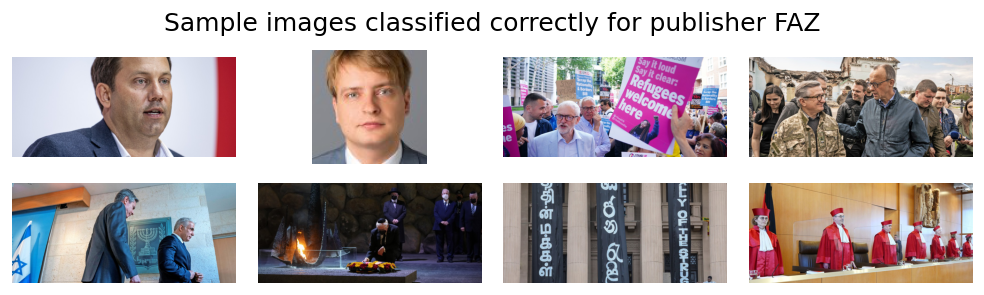

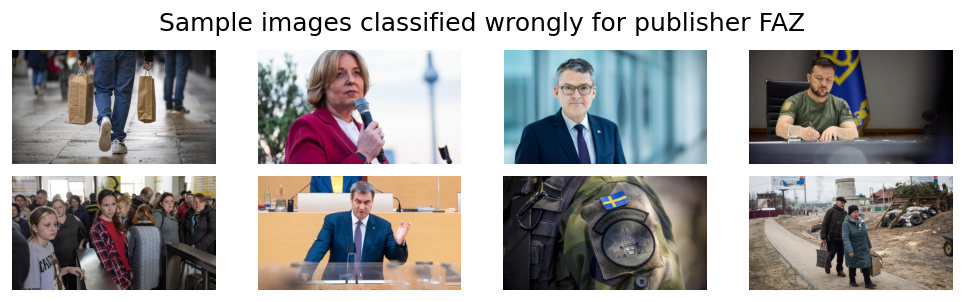

In [19]:
fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher FAZ', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_correct_faz[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_correct_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher FAZ', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_incorrect_faz[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_incorrect_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

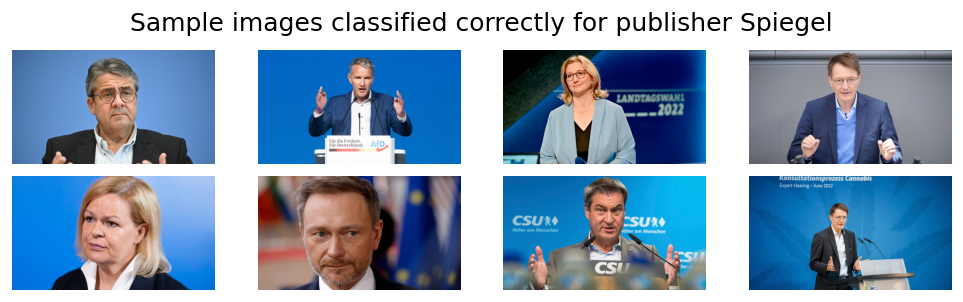

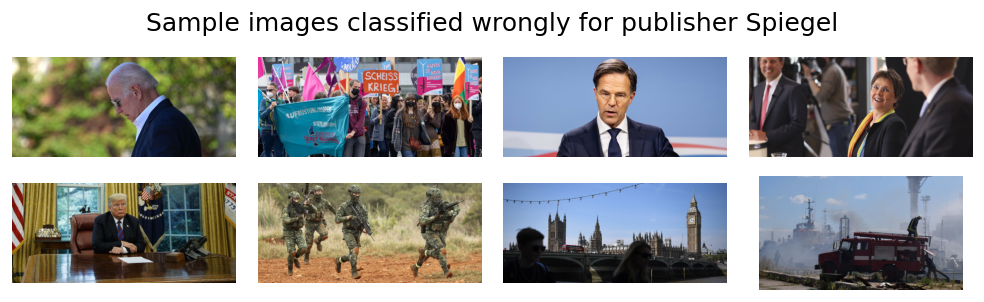

In [20]:
fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher Spiegel', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_correct_spiegel[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_correct_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher Spiegel', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_incorrect_spiegel[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_incorrect_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

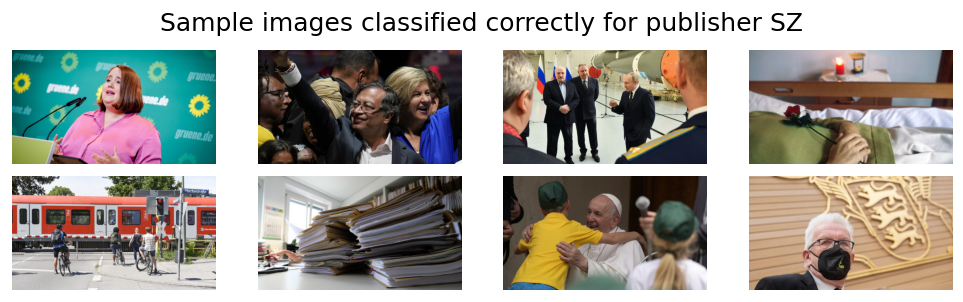

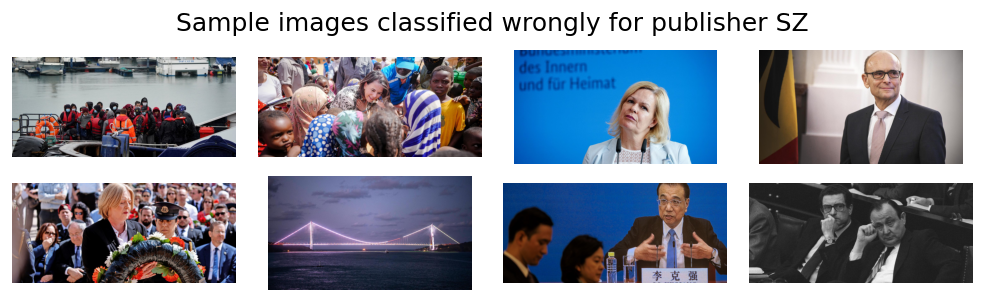

In [21]:
fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher SZ', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_correct_sz[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_correct_sz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher SZ', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_incorrect_sz[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_incorrect_sz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

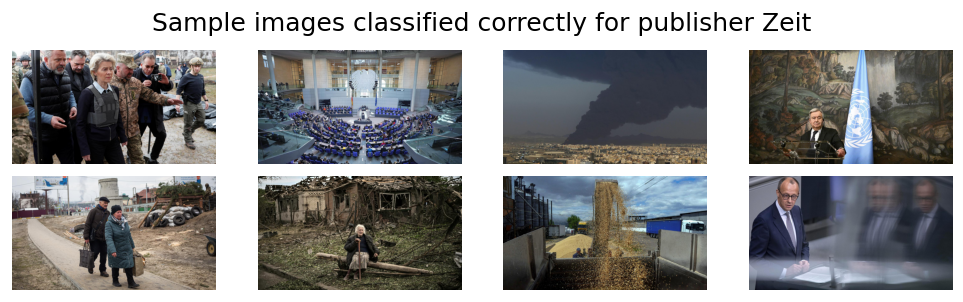

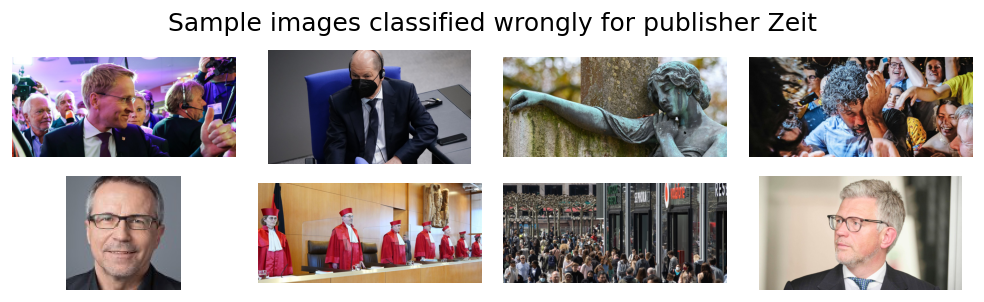

In [22]:
fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher Zeit', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_correct_zeit[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_correct_zeit)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(2, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher Zeit', fontsize=15, y=0.68)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.1, 
                    hspace=0.1)

for n,cate in enumerate(df_test_incorrect_zeit[:8]):
    ax = plt.subplot(2,4,n+1)
    index = np.random.choice(df_test_incorrect_zeit)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

## Dataset B - FAZ (mid-right) and Spiegel (mid-left) (binary classification)

In [27]:
with open('image_data_array_fazsp.pickle','rb') as file:
    data = pickle.load(file)
    
X_test,y_test = data[1],data[4]

y_test_hotcode = keras.utils.to_categorical(y_test)

In [28]:
model_path = "model_h5_file_fazsp"

In [31]:
os.listdir('model_h5_file_fazsp')

['cnn_model_fazsp.h5',
 'vgg16_model_array_trainable_fazsp.h5',
 'vgg16_model_array_fazsp.h5']

In [40]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m 
}


In [41]:
model_eval ={'accuracy':[],'recall':[],'precision':[],'f1':[],'run_time':[]}
models = []
for model in os.listdir('model_h5_file_fazsp'):
    models.append(model)
    classification = keras.models.load_model('model_h5_file_fazsp/'+str(model), custom_objects=dependencies)
    time1= time.time()
    y_pred = classification.predict(X_test)
    time2= time.time()
    run_time = time2-time1
    y_pred = np.argmax(y_pred,axis =1)
    model_eval['accuracy'].append(accuracy_score(y_test, y_pred))
    model_eval['recall'].append(recall_score(y_test,y_pred,average = 'macro'))
    model_eval['precision'].append(precision_score(y_test, y_pred,average= 'macro'))
    model_eval['f1'].append(f1_score(y_test, y_pred, average = 'macro'))
    model_eval['run_time'].append(run_time)

In [42]:
model_eval = pd.DataFrame(model_eval,index = models)
model_eval

accuracy    recall  precision        f1  \
cnn_model_fazsp.h5                    0.676787  0.604066   0.648574  0.602658   
vgg16_model_array_trainable_fazsp.h5  0.732615  0.723704   0.714754  0.717792   
vgg16_model_array_fazsp.h5            0.733595  0.723901   0.715442  0.718423   

                                       run_time  
cnn_model_fazsp.h5                     2.178975  
vgg16_model_array_trainable_fazsp.h5  24.136954  
vgg16_model_array_fazsp.h5            24.378965

In [43]:
int_category_map = {1: 'spiegel', 0:'faz'}

In [44]:
best_model = keras.models.load_model(model_path+ "/"+"vgg16_model_array_fazsp.h5")
y_pred = np.argmax(best_model.predict(X_test),axis =1)

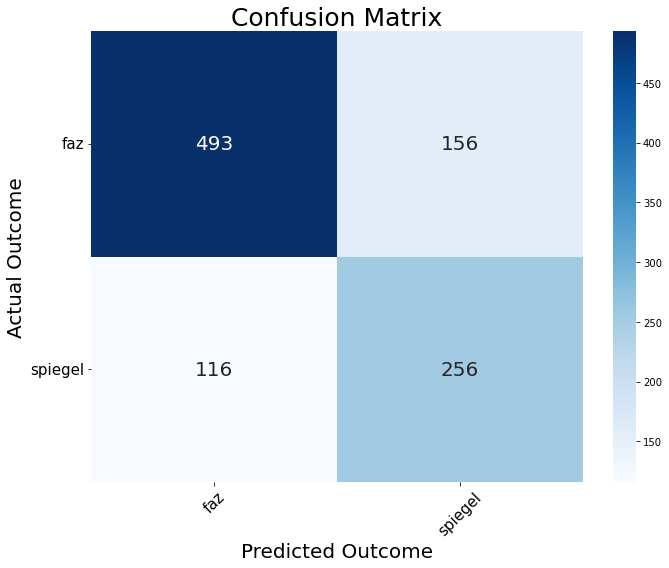

In [45]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Check Data with wrong prediction Results**

In [46]:
work_data_df_test = pd.read_csv('work_data_df.csv')
work_data_df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

y_test_adj = y_test.reset_index(drop=True)

work_data_df_test = pd.concat([work_data_df_test, y_test_adj, pd.Series(y_pred)], axis=1)
work_data_df_test.rename(columns={0: 'actual', 1: 'pred'}, inplace=True)
work_data_df_test['misclassification'] = work_data_df_test['actual'] == work_data_df_test['pred']

mistakes_faz = work_data_df_test.loc[(work_data_df_test['misclassification'] == False) & 
                                     (work_data_df_test['category'] == 'images_faz'), 'image_path']

mistakes_spiegel = work_data_df_test.loc[(work_data_df_test['misclassification'] == False) & 
                                     (work_data_df_test['category'] == 'images_spiegel'), 'image_path']


correct_faz = work_data_df_test.loc[(work_data_df_test['misclassification'] == True) & 
                                     (work_data_df_test['category'] == 'images_faz'), 'image_path']

correct_spiegel = work_data_df_test.loc[(work_data_df_test['misclassification'] == True) & 
                                     (work_data_df_test['category'] == 'images_spiegel'), 'image_path']

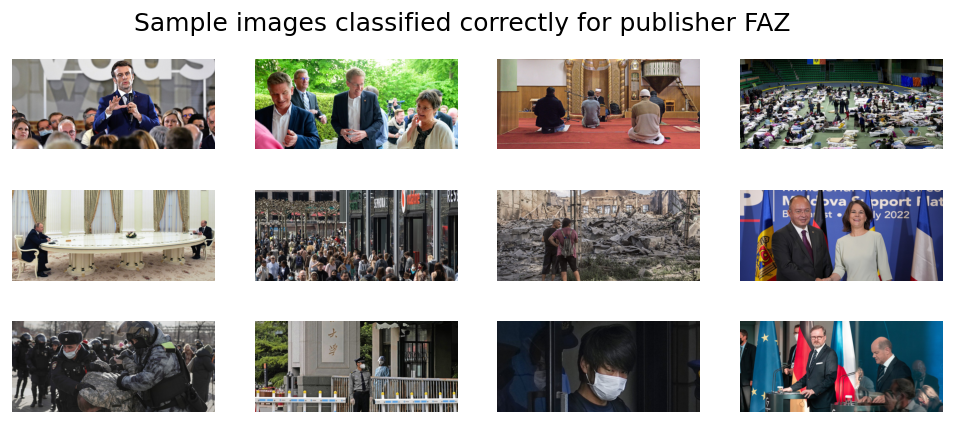

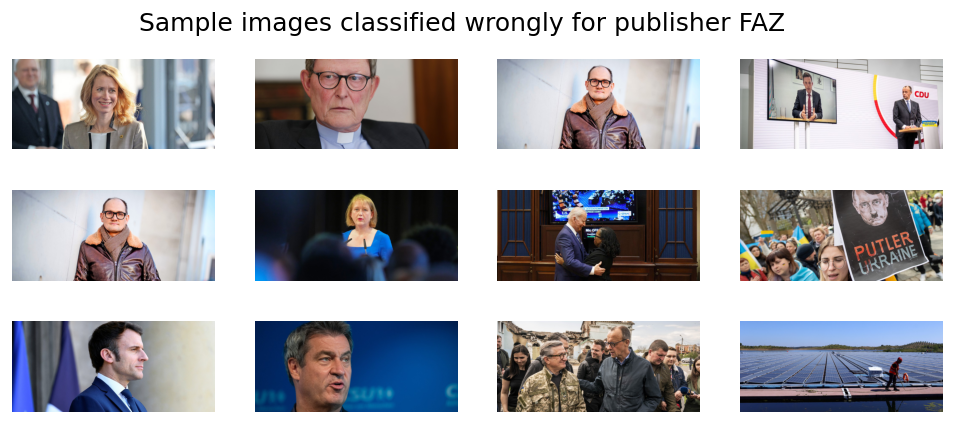

In [47]:
fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher FAZ', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(correct_faz[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(correct_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher FAZ', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(mistakes_faz[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(mistakes_faz)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

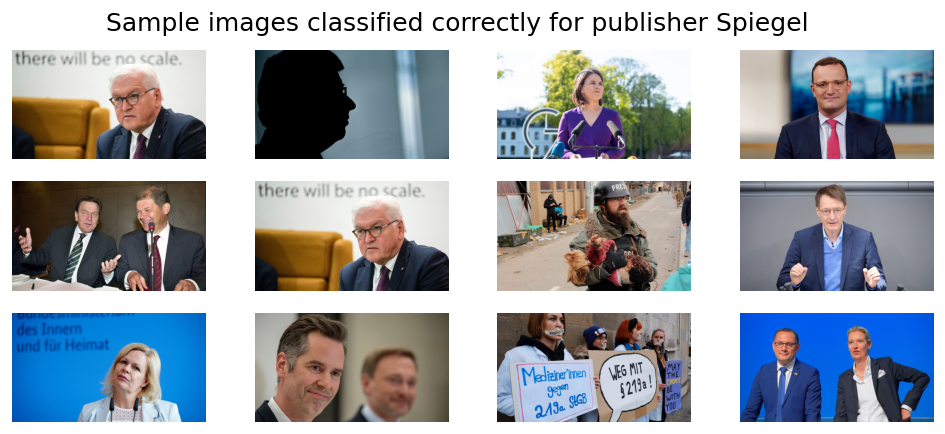

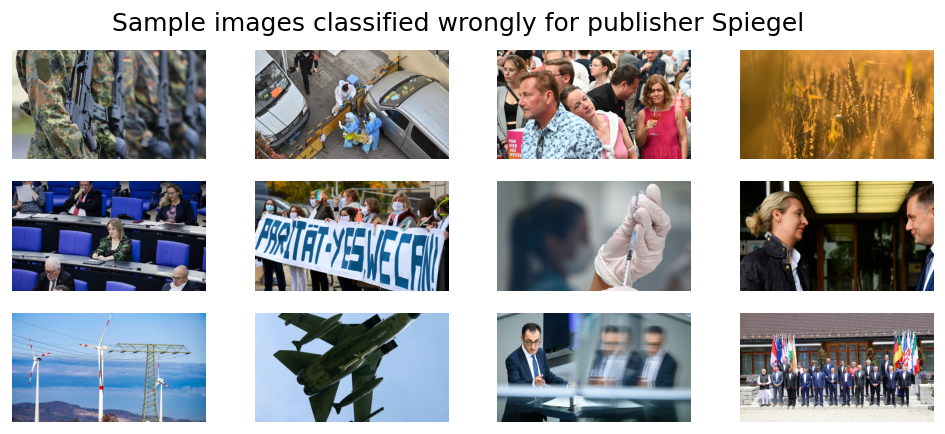

In [48]:
fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified correctly for publisher Spiegel', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(correct_spiegel[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(correct_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

fig, ax = plt.subplots(3, 4,figsize= (10,4), dpi=120)
fig.suptitle('Sample images classified wrongly for publisher Spiegel', fontsize=15)
fig.subplots_adjust(top=0.9)

for n,cate in enumerate(mistakes_spiegel[:12]):
    ax = plt.subplot(3,4,n+1)
    index = np.random.choice(mistakes_spiegel)
    img = mpimg.imread(index)
    plt.imshow(img)
    plt.axis('off')

## Dataset C - FAZ (mid-right) and Zeit (mid-left) (binary classification)

In [120]:
df_text = pd.read_csv('df_text.csv').drop('Unnamed: 0', axis=1)
df_text.dropna(inplace=True)
df_text.reset_index(drop=True, inplace=True)

In [121]:
df_text

teaser publisher
0     Selenskyj skeptisch angesichts geplanter Verha...       faz
1     Die SPD glaubt, sich ausreichend von Gerhard S...       faz
2     Dauernd hieß es, China sei die größte Herausfo...       faz
3     Der Krieg in der Ukraine wird zur Folge haben,...       faz
4     Der russische Überfall zeigt: Das Gas-Projekt ...       faz
...                                                 ...       ...
4404  NS-Opfer, die wegen ihrer sexuellen und geschl...      zeit
4405  Wegen steigender Mieten und Energiepreise soll...      zeit
4406  Für die Fahrer von Mähmaschinen sind Rehkitze ...      zeit
4407  Erdoğan hat es geschafft: Die Ukraine und Russ...      zeit
4408  Die Ukraine und Russland haben eine Vereinbaru...      zeit

[4409 rows x 2 columns]

In [122]:
with open('text_data_array_fazzeit.pickle','rb') as file:
    data = pickle.load(file)

In [123]:
X_test,y_test, ind_test = data[1],data[3],data[5]

In [124]:
X_test,y_test = data[1],data[3]
y_test_hotcode = keras.utils.to_categorical(y_test)

In [125]:
lstm_model = keras.models.load_model('models_text_fazzeit/basic_lstm_model_fazzeit.h5')

In [126]:
y_pred = keras.utils.to_categorical(np.argmax(lstm_model.predict(X_test),axis =1))
y_test

print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.6768707482993197
recall : 0.6770132200722965
precision : 0.6776755852842808
f1 : 0.6766109309287673


In [127]:
category_int_map = {'zeit': 1, 'faz': 0}
int_category_map = {1: 'zeit', 0:'faz'}

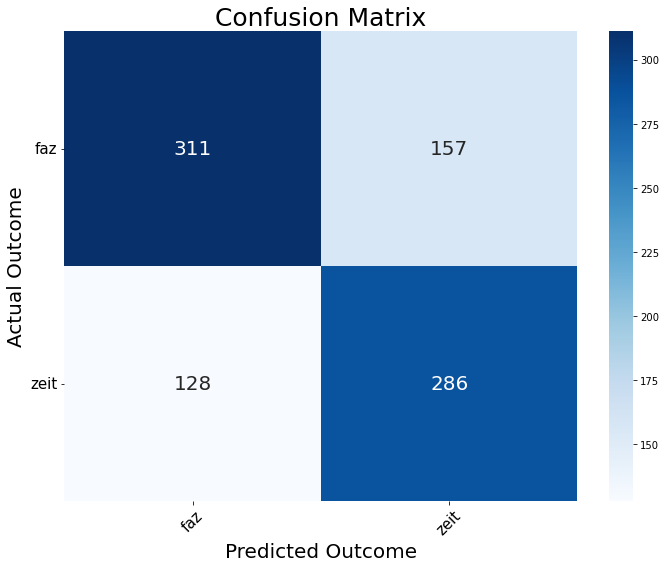

In [128]:
y_test_flat = np.select([y_test[:, 0] == 0, y_test[:, 0] == 1], [1, 0], y_test[:, 0])
y_pred = np.argmax(lstm_model.predict(X_test),axis =1)

plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_pred, y_test_flat),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Check Data with wrong prediction Results**

In [129]:
ind_correct_class = ind_test[y_test_flat == y_pred]
ind_wrong_class = ind_test[y_test_flat != y_pred]
len(ind_wrong_class)

285

In [130]:
mistakes_faz = df_text.loc[(df_text['publisher'] == 'faz') & (df_text.index.isin(ind_wrong_class)), 'teaser']
correct_faz = df_text.loc[(df_text['publisher'] == 'faz') & (df_text.index.isin(ind_correct_class)), 'teaser']

mistakes_zeit = df_text.loc[(df_text['publisher'] == 'zeit') & (df_text.index.isin(ind_wrong_class)), 'teaser']
correct_zeit = df_text.loc[(df_text['publisher'] == 'zeit') & (df_text.index.isin(ind_correct_class)), 'teaser']

In [131]:
print('\033[1m' + 'FAZ: Wrong classifications\n' + '\033[0m')

for i in np.random.choice(mistakes_faz, 5):
    print(i+'\n')
    
print('\033[1m' + '\nFAZ: Correct classifications\n' + '\033[0m')

for i in np.random.choice(correct_faz, 5):
    print(i+'\n')

FAZ: Wrong classifications

Nur ein „Feind von Zivilisation und Menschlichkeit“ könne Raketen auf eine pädagogische Universität abfeuern, sagt der ukrainische Präsident. Die Menschen im Donezker Gebiet werden zur Flucht aufgerufen. Der Überblick.

Laut eines Berichts erörtert die Bundesregierung die Einführung einer Maskenpflicht ab Oktober. Wie diese genau ausgestaltet werden soll, stehe noch nicht fest.

Die Republik Moldau will über eine Aufnahme in die EU verhandeln. Verständlich ist das durchaus. Realistisch allerdings nicht.

Die Ampelkoalition hat sich vorgenommen, die Evakuierungsmission der Bundeswehr in Afghanistan aufzuarbeiten. Nun gibt es ein Gremium dafür.

Deutschlands Außenministerin sieht die Stabilität in der Region durch den Krieg in der Ukraine zusätzlich gefährdet. An die serbischen Gebiete in Bosnien-Hercegovina richtet sie eine Warnung.


FAZ: Correct classifications

Nach mehreren schweren Schusswaffenangriffen forderten in Amerika Zehntausende am Wochenende str

In [132]:
print('\033[1m' + 'Zeit: Wrong classifications\n' + '\033[0m')

for i in np.random.choice(mistakes_zeit, 5):
    print(i+'\n')
    
print('\033[1m' + '\nZeit: Correct classifications\n' + '\033[0m')

for i in np.random.choice(correct_zeit, 5):
    print(i+'\n')

Zeit: Wrong classifications

Der japanische Regierungschef will künftig mindestens zwei Prozent des BIP für Rüstung ausgeben. Er wolle das Vorhaben seines ermordeten Vorgängers Shinzō Abe fortführen.

Russland zieht nach Angaben der Ukraine immer mehr Truppen im Südosten zusammen. Der Hafen von Mariupol soll komplett eingenommen sein. Das war die Nacht.

Ab sofort gilt die Impfpflicht im Gesundheitswesen. Doch vor allem da, wo sie besonders nötig wäre, dürfte ihre Wirkung begrenzt bleiben.

Mit immerhin fünf Prozentpunkten Vorsprung geht Amtsinhaber Emmanuel Macron in die Stichwahl gegen Marine Le Pen am 24. April. Vier Lehren aus diesem ersten Wahlgang

Der türkische Präsident sucht aus Prinzip Streit. Das gilt auch für seine Blockade eines Nato-Beitritts von Schweden und Finnland. Aber seine Einwände sind diesmal ernst.


Zeit: Correct classifications

Trotz des Rücktritts des Regierungschef halten die Proteste an. Das Verteidigungsministerium wies Sicherheitskräfte an, auf Leute zu 